# カテゴリ分布の学習と予測

シミュレーションデータ (最初の20回): [5 1 6 ... 6 4 6]
----------------------------------------


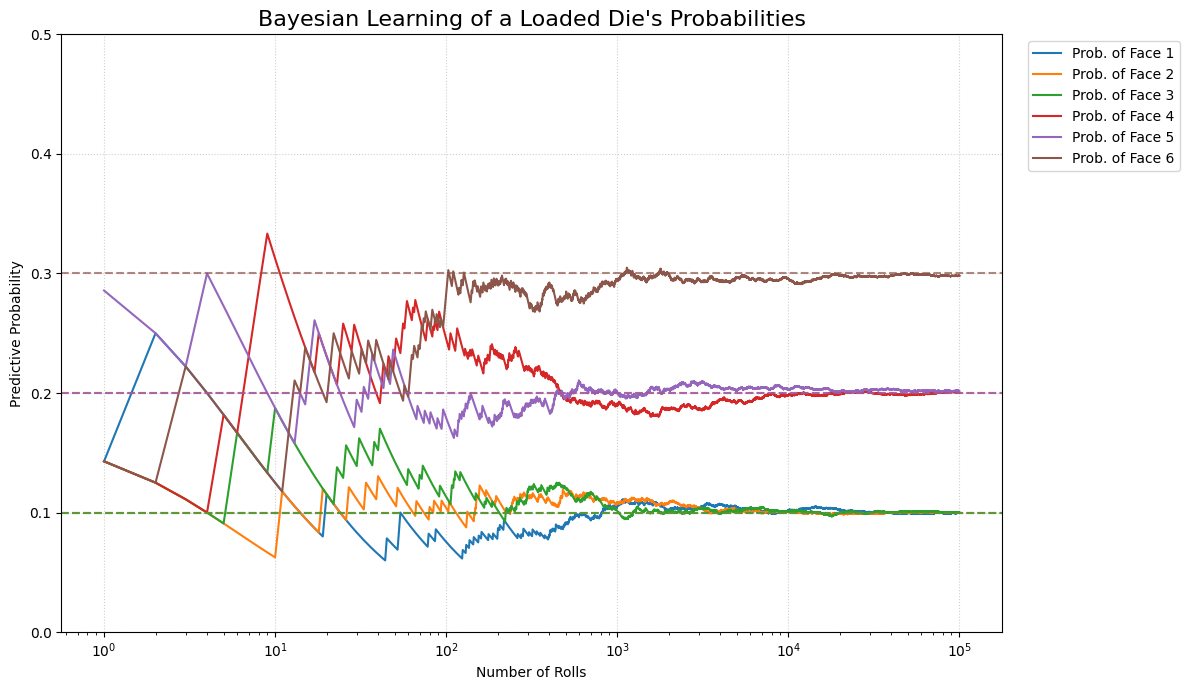

---最終結果---
各目の観測回数: [ 9993 10026  9996 20014 20172 29799]
真の確率:         ['0.100', '0.100', '0.100', '0.200', '0.200', '0.300']
最終的な予測確率: ['0.100', '0.100', '0.100', '0.200', '0.202', '0.298']


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. シナリオ設定 ---

# サイコロの面の数
K = 6

# イカサマサイコロの「真の」確率ベクトル (合計は1)
pi_true = np.array([0.1, 0.1, 0.1, 0.2, 0.2, 0.3])

# 事前分布のハイパーパラメータα (α_k=1は無情報な事前分布を示す)
alpha_prior = np.ones(K)

# サイコロを振る回数
num_trials = 100000

# サイコロを振った結果をシミュレーション (目は0-5で表現)
# np.random.choiceは指定した確率分布に従うサンプリングを行う
data = np.random.choice(K, size=num_trials, p=pi_true)
print(f"シミュレーションデータ (最初の20回): {data + 1}")  # 1-6で表示
print("-" * 40)


# --- 2. ベイズ学習と予測の過程を記録 ---

# 記録用のリスト (各試行後の予測確率を保存)
predictive_history = []

for i in range(num_trials):
    # i回目までのデータ
    current_data = data[: i + 1]

    # 各目が出た回数を数える (N_1, ..., N_K)
    # np.bincountは整数の出現回数を高速に数える
    counts = np.bincount(current_data, minlength=K)

    # 事後分布のパラメータを計算 (学習)
    alpha_hat = alpha_prior + counts

    # 次に各目が出る確率を予測
    pred_probs = alpha_hat / np.sum(alpha_hat)

    # 結果を記録
    predictive_history.append(pred_probs)

# 配列に変換
predictive_history = np.array(predictive_history)


# --- 3. 結果の可視化 ---

plt.figure(figsize=(12, 7))

# 各目(1-6)の予測確率の推移をプロット
for k in range(K):
    plt.plot(
        range(1, num_trials + 1),
        predictive_history[:, k],
        label=f"Prob. of Face {k + 1}",
    )

# 真の確率を破線でプロット
for k in range(K):
    plt.axhline(y=pi_true[k], color=f"C{k}", linestyle="--", alpha=0.7)

plt.title("Bayesian Learning of a Loaded Die's Probabilities", fontsize=16)
plt.xlabel("Number of Rolls")
plt.xscale("log")
plt.ylabel("Predictive Probability")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.ylim(0, 0.5)  # y軸の範囲を調整して見やすくする
plt.tight_layout()
plt.show()

# 最終的な予測確率を表示
final_counts = np.bincount(data, minlength=K)
print("---最終結果---")
print(f"各目の観測回数: {final_counts}")
print(f"真の確率:         {[f'{p:.3f}' for p in pi_true]}")
print(f"最終的な予測確率: {[f'{p:.3f}' for p in predictive_history[-1]]}")
